# Did you like the movie? - Multiple Linear Regression

In this stage we will perform a multiple linear regression analysis in order to predict a movie's fan rating based on all the information we have about the movie.  We will use the `statsmodels` approach, both with and without considering an intercept.

## Import libraries

As usual, we load the libraries we need and configure our plots.

In [1]:
# Data wrangling
# ==============================================================================
import pandas as pd
import numpy as np

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocessing and modeling
# ==============================================================================
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error,root_mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

# Configuring matplotlib
# ==============================================================================
#plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
#style.use('ggplot') or plt.style.use('ggplot')

# Configuring warnings
# ==============================================================================
import warnings
#warnings.filterwarnings('ignore')

## Loading the dataset

We load here our clean dataset

In [2]:
movies = pd.read_csv('movie_DB2.csv', index_col='Title')
movies.head()

,Year,Genre,Duration,Budget,Revenue,Imdb,Critic_1,Critic_2,Critic_3,Personal,Fans
Title,,,,,,,,,,,
The shawshank redemption,1994,Drama,142,28.341469,2.343110,93.0,99,98.0,84.0,80.0,82.00
The godfather,1972,Crime,175,134.966411,1.620367,92.0,80,97.0,91.0,100.0,78.35
The godfather part ii,1974,Crime,202,57.300000,1.129952,90.0,82,75.0,91.0,90.0,76.60
12 angry men,1957,Crime,96,4.360000,0.689845,90.0,81,80.0,86.0,96.0,77.25
The lord of the rings the return of the king,2003,Action,201,377.845905,1.642758,89.0,98,80.0,76.0,94.0,80.20


In [3]:
movies.describe()

,Year,Duration,Budget,Revenue,Imdb,Critic_1,Critic_2,Critic_3,Personal,Fans
count,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000
mean,1998.663793,133.232759,100.485144,230.495803,81.922414,86.525862,79.465517,74.163793,82.862069,81.404526
std,16.571292,26.991579,97.919962,302.566495,7.191965,8.996097,10.518250,16.323333,10.206474,4.430339
min,1954.000000,75.000000,0.960000,0.042004,67.000000,63.000000,58.000000,34.000000,57.000000,70.125000
25%,1988.750000,115.000000,19.125929,1.261599,77.750000,80.000000,71.000000,72.000000,75.000000,78.341447
50%,2000.500000,130.000000,71.000000,61.721652,81.000000,89.000000,78.000000,78.000000,85.000000,81.175000
75%,2013.250000,150.250000,150.000000,407.220654,86.250000,93.250000,88.250000,84.000000,90.000000,84.291209
max,2023.000000,202.000000,390.305102,1155.046416,97.000000,100.000000,99.000000,100.000000,100.000000,91.636364


## Relations between variables

The first step in developing a multiple linear model is to study the relationship that exists between the different variables. This information is very useful when identifying which are the best predictors for the model, and for detecting collinearity between predictors.

In [4]:
corr_matrix=movies.select_dtypes(include=['float64', 'int']).corr(method='pearson')
corr_matrix

,Year,Duration,Budget,Revenue,Imdb,Critic_1,Critic_2,Critic_3,Personal,Fans
Year,1.000000,0.089585,0.374391,0.407548,-0.198897,0.018987,-0.074825,0.035310,-0.006138,-0.102908
Duration,0.089585,1.000000,0.357445,0.001632,0.267115,-0.046812,0.079771,0.149750,0.154310,-0.086938
Budget,0.374391,0.357445,1.000000,0.226216,-0.036421,0.007580,0.050008,0.250856,0.054847,-0.129241
Revenue,0.407548,0.001632,0.226216,1.000000,-0.304148,0.107949,-0.260043,-0.173831,0.136955,0.149448
Imdb,-0.198897,0.267115,-0.036421,-0.304148,1.000000,0.011657,0.304756,0.252023,0.049962,-0.066110
Critic_1,0.018987,-0.046812,0.007580,0.107949,0.011657,1.000000,0.345407,0.208263,-0.045324,0.197175
Critic_2,-0.074825,0.079771,0.050008,-0.260043,0.304756,0.345407,1.000000,0.394190,0.031626,0.030915
Critic_3,0.035310,0.149750,0.250856,-0.173831,0.252023,0.208263,0.394190,1.000000,-0.221895,0.132864
Personal,-0.006138,0.154310,0.054847,0.136955,0.049962,-0.045324,0.031626,-0.221895,1.000000,0.011153
Fans,-0.102908,-0.086938,-0.129241,0.149448,-0.066110,0.197175,0.030915,0.132864,0.011153,1.000000


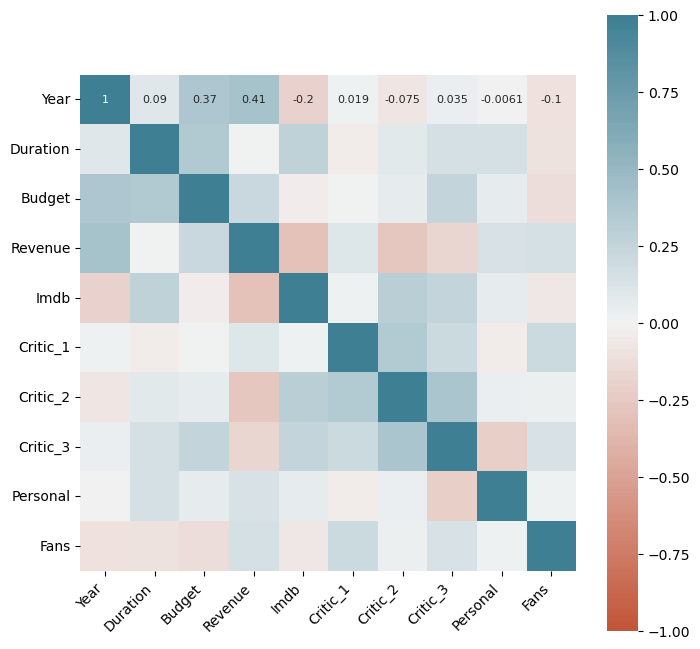

In [5]:
# Heatmap for correlation matrix
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

sns.heatmap(
    corr_matrix,
    annot     = corr_matrix,
    cbar      = True,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220,n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

c:\Users\jorge\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jorge\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jorge\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jorge\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

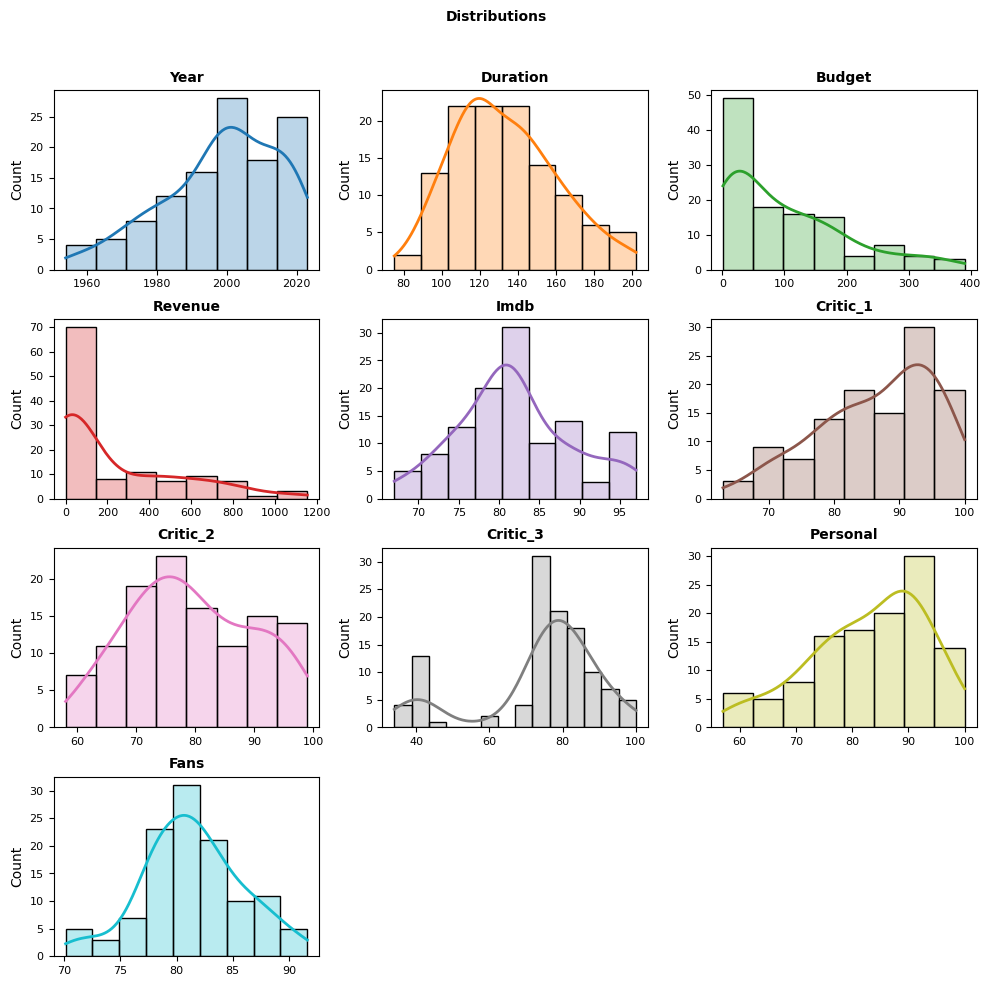

In [6]:
# Distribution plots for each numerical variable
# ==============================================================================
# 
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 10))
axes = axes.flat
columnas_numeric = movies.select_dtypes(include=['float64', 'int']).columns

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = movies,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 8)
    axes[i].set_xlabel("")


fig.delaxes(axes[10])
fig.delaxes(axes[11])
fig.tight_layout(pad=1)
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distributions', fontsize = 10, fontweight = "bold");

## Model fitting

We will fit a linear regression model with `Fans` as the response variable, and all the other variables as predictors. To this end, we will split the data in two groups, a training set and a testing set. We will use the **Statsmodels** library. **Statsmodels** provides two ways of training the model:

- Giving a formula for the model and feeding it with a `DataFrame` for the training test that includes the response variable and the predictors. This is similar to the method used in **R**.

- Giving two matrices, a predictor matrix and a response matrix.

In [7]:
# Train-test splitting
# ==============================================================================
X = movies.drop(columns=['Genre','Fans'])
y = movies['Fans']

In [8]:
X.head()

,Year,Duration,Budget,Revenue,Imdb,Critic_1,Critic_2,Critic_3,Personal
Title,,,,,,,,,
The shawshank redemption,1994,142,28.341469,2.343110,93.0,99,98.0,84.0,80.0
The godfather,1972,175,134.966411,1.620367,92.0,80,97.0,91.0,100.0
The godfather part ii,1974,202,57.300000,1.129952,90.0,82,75.0,91.0,90.0
12 angry men,1957,96,4.360000,0.689845,90.0,81,80.0,86.0,96.0
The lord of the rings the return of the king,2003,201,377.845905,1.642758,89.0,98,80.0,76.0,94.0


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 512,
                                        shuffle      = True
                                    )

In [10]:
X.columns

Index(['Year', 'Duration', 'Budget', 'Revenue', 'Imdb', 'Critic_1', 'Critic_2',
       'Critic_3', 'Personal'],
      dtype='object')

### Model fitting using a formula

#### With intercept

In [11]:
# Model fitting using a formula
# ==============================================================================

#data_train = pd.DataFrame(
#                   np.hstack((X_train, y_train)),
#                   columns=['tv', 'radio', 'newspaper', 'sales']
#              )
movies_train = pd.DataFrame(np.hstack((X_train, y_train)),columns=['Year', 'Duration', 'Budget', 'Revenue', 'Imdb', 'Critic_1', 'Critic_2',
       'Critic_3', 'Personal','Fans'])

In [12]:
modelf = smf.ols(formula = 'Fans ~ Year + Duration + Budget + Revenue + Imdb + Critic_1 + Critic_2 + Critic_3 + Personal', data = movies_train)
modelf = modelf.fit()
modelf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Fans   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     1.672
Date:                Fri, 07 Jun 2024   Prob (F-statistic):              0.109
Time:                        20:45:43   Log-Likelihood:                -259.95
No. Observations:                  92   AIC:                             539.9
Df Residuals:                      82   BIC:                             565.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    112.3598     63.671      1.765      0.081     -14.303     239.022
Year          -0.0182      0.031     -0.583      0.562      -0.081       0.044
Duration      -0.0135      0.019     -0.701      0.485      -0.052       0.025
Budget        -0.0095      0.006     -1.638      0.105      -0.021       0.002
Revenue        0.0037      0.002      2.070      0.042       0.000       0.007
Imdb          -0.0773      0.079     -0.984      0.328      -0.234       0.079
Critic_1       0.0478      0.059      0.810      0.420      -0.070       0.165
Critic_2       0.0172      0.053      0.326      0.745      -0.088       0.122
Critic_3       0.0682      0.032      2.137      0.036       0.005       0.132
Personal       0.0379      0.048      0.785      0.435      -0.058       0.134
==============================================================================
Omnibus:                        1.802   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.406   Jarque-Bera (JB):                1.215
Skew:                          -0.227   Prob(JB):                        0.545
Kurtosis:                       3.332   Cond. No.                     2.87e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.87e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We observe that `R^2` is very small, so we suspect that the intercept must be zero.

#### Without intercept

In [13]:
# Model fitting using a formula
# ==============================================================================
modelf_noint = smf.ols(formula = 'Fans ~ 0 + Year + Duration + Budget + Revenue + Imdb + Critic_1 + Critic_2 + Critic_3 + Personal', data = movies_train)
modelf_noint = modelf_noint.fit()
modelf_noint.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   Fans   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                              3529.
Date:                Fri, 07 Jun 2024   Prob (F-statistic):                   2.77e-103
Time:                        20:45:43   Log-Likelihood:                         -261.67
No. Observations:                  92   AIC:                                      541.3
Df Residuals:                      83   BIC:                                      564.0
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Year           0.0365      0.004      8.546      0.000       0.028       0.045
Duration      -0.0161      0.020     -0.824      0.412      -0.055       0.023
Budget        -0.0114      0.006     -1.980      0.051      -0.023     5.1e-05
Revenue        0.0027      0.002      1.573      0.120      -0.001       0.006
Imdb          -0.0491      0.078     -0.631      0.530      -0.204       0.106
Critic_1       0.0596      0.059      1.004      0.318      -0.058       0.178
Critic_2       0.0123      0.053      0.231      0.818      -0.094       0.118
Critic_3       0.0655      0.032      2.028      0.046       0.001       0.130
Personal       0.0488      0.048      1.007      0.317      -0.048       0.145
==============================================================================
Omnibus:                        2.028   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.363   Jarque-Bera (JB):                1.420
Skew:                          -0.194   Prob(JB):                        0.492
Kurtosis:                       3.469   Cond. No.                         361.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In effect, eliminating the intercept increases `R^2`.

## Model fitting using a formula without intercept

Using the formula approach to fitting the model without intercept gives the following Regression Analysis Summary

In [14]:
# Model fitting using a formula
# ==============================================================================
modelf_noint = smf.ols(formula = 'Fans ~ 0 + Year + Duration + Budget + Revenue + Imdb + Critic_1 + Critic_2 + Critic_3 + Personal', data = movies_train)
modelf_noint = modelf_noint.fit()
modelf_noint.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   Fans   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                              3529.
Date:                Fri, 07 Jun 2024   Prob (F-statistic):                   2.77e-103
Time:                        20:45:43   Log-Likelihood:                         -261.67
No. Observations:                  92   AIC:                                      541.3
Df Residuals:                      83   BIC:                                      564.0
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Year           0.0365      0.004      8.546      0.000       0.028       0.045
Duration      -0.0161      0.020     -0.824      0.412      -0.055       0.023
Budget        -0.0114      0.006     -1.980      0.051      -0.023     5.1e-05
Revenue        0.0027      0.002      1.573      0.120      -0.001       0.006
Imdb          -0.0491      0.078     -0.631      0.530      -0.204       0.106
Critic_1       0.0596      0.059      1.004      0.318      -0.058       0.178
Critic_2       0.0123      0.053      0.231      0.818      -0.094       0.118
Critic_3       0.0655      0.032      2.028      0.046       0.001       0.130
Personal       0.0488      0.048      1.007      0.317      -0.048       0.145
==============================================================================
Omnibus:                        2.028   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.363   Jarque-Bera (JB):                1.420
Skew:                          -0.194   Prob(JB):                        0.492
Kurtosis:                       3.469   Cond. No.                         361.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We have a large value for $R^2$, very close to $1$. However, the $p$-value for some coefficients is greater thatn $0.05$, which indicates that some predictors are not really independent, and we must eliminate them, one at a time. We start by eliminating the variable `Critic_2`, given that its $p$-value is the largest.

In [15]:
# Model fitting using a formula
# ==============================================================================
##PARA MI LA MAS ALTA ES CRITIC 2 ENTONCES ES LA QUE QUITAMOS##ya lo dije 
modelf_noint = smf.ols(formula = 'Fans ~ 0 + Year + Duration + Budget + Revenue + Imdb + Critic_1 + Critic_3 + Personal', data = movies_train)

modelf_noint = modelf_noint.fit()
modelf_noint.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   Fans   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                              4015.
Date:                Fri, 07 Jun 2024   Prob (F-statistic):                   4.33e-105
Time:                        20:45:43   Log-Likelihood:                         -261.70
No. Observations:                  92   AIC:                                      539.4
Df Residuals:                      84   BIC:                                      559.6
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Year           0.0365      0.004      8.592      0.000       0.028       0.045
Duration      -0.0162      0.019     -0.835      0.406      -0.055       0.022
Budget        -0.0111      0.006     -1.986      0.050      -0.022    1.41e-05
Revenue        0.0026      0.002      1.582      0.118      -0.001       0.006
Imdb          -0.0451      0.075     -0.597      0.552      -0.195       0.105
Critic_1       0.0646      0.055      1.179      0.242      -0.044       0.174
Critic_3       0.0670      0.031      2.133      0.036       0.005       0.129
Personal       0.0506      0.048      1.061      0.292      -0.044       0.145
==============================================================================
Omnibus:                        2.088   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.352   Jarque-Bera (JB):                1.476
Skew:                          -0.200   Prob(JB):                        0.478
Kurtosis:                       3.475   Cond. No.                         342.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Again, we observe that $R^2$ is high. The next variable to eliminate is `Imdb` for which the $p$-value is $0.552$

In [16]:
# Model fitting using a formula
# ==============================================================================
##la mas alta es imdb quito esa  ##YA LO DIJE 
modelf_noint = smf.ols(formula = 'Fans ~ 0 + Year + Duration + Budget + Revenue + Critic_1 + Critic_3 + Personal', data = movies_train)

modelf_noint = modelf_noint.fit()
modelf_noint.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   Fans   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                              4623.
Date:                Fri, 07 Jun 2024   Prob (F-statistic):                   7.33e-107
Time:                        20:45:43   Log-Likelihood:                         -261.89
No. Observations:                  92   AIC:                                      537.8
Df Residuals:                      85   BIC:                                      555.4
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Year           0.0351      0.003     10.098      0.000       0.028       0.042
Duration      -0.0191      0.019     -1.025      0.308      -0.056       0.018
Budget        -0.0104      0.005     -1.910      0.060      -0.021       0.000
Revenue        0.0028      0.002      1.807      0.074      -0.000       0.006
Critic_1       0.0656      0.055      1.201      0.233      -0.043       0.174
Critic_3       0.0628      0.031      2.060      0.042       0.002       0.123
Personal       0.0469      0.047      0.996      0.322      -0.047       0.140
==============================================================================
Omnibus:                        1.820   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.403   Jarque-Bera (JB):                1.231
Skew:                          -0.163   Prob(JB):                        0.540
Kurtosis:                       3.463   Cond. No.                         250.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now, the next variable to be eliminated is `Personal`. We keep on eliminating variables until all $p$-values are smaller than $0.05$.

In [17]:
# Model fitting using a formula
# ==============================================================================
##la mas alta es es personal entonces la quito ##YA LO DIJE 
modelf_noint = smf.ols(formula = 'Fans ~ 0 + Year + Duration + Budget + Revenue + Critic_1 + Critic_3', data = movies_train)

modelf_noint = modelf_noint.fit()
modelf_noint.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   Fans   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                              5394.
Date:                Fri, 07 Jun 2024   Prob (F-statistic):                   1.56e-108
Time:                        20:45:43   Log-Likelihood:                         -262.43
No. Observations:                  92   AIC:                                      536.9
Df Residuals:                      86   BIC:                                      552.0
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Year           0.0372      0.003     13.854      0.000       0.032       0.043
Duration      -0.0162      0.018     -0.879      0.382      -0.053       0.020
Budget        -0.0106      0.005     -1.942      0.055      -0.021       0.000
Revenue        0.0030      0.002      1.950      0.054   -5.89e-05       0.006
Critic_1       0.0599      0.054      1.104      0.273      -0.048       0.168
Critic_3       0.0567      0.030      1.898      0.061      -0.003       0.116
==============================================================================
Omnibus:                        2.471   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.291   Jarque-Bera (JB):                1.897
Skew:                          -0.199   Prob(JB):                        0.387
Kurtosis:                       3.580   Cond. No.                         248.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now, the next variable to be eliminated is `Duration`. We keep on eliminating variables until all $p$-values are smaller than $0.05$.

In [18]:
# Model fitting using a formula
# ==============================================================================
##LA MAS GRANDE ES DURATION ENTONCES LA QUITO ##YA LO DIJE
modelf_noint = smf.ols(formula = 'Fans ~ 0 + Year + Budget + Revenue + Critic_1 + Critic_3', data = movies_train)
modelf_noint = modelf_noint.fit()
modelf_noint.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   Fans   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                              6490.
Date:                Fri, 07 Jun 2024   Prob (F-statistic):                   2.70e-110
Time:                        20:45:43   Log-Likelihood:                         -262.84
No. Observations:                  92   AIC:                                      535.7
Df Residuals:                      87   BIC:                                      548.3
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Year           0.0360      0.002     15.660      0.000       0.031       0.041
Budget        -0.0118      0.005     -2.234      0.028      -0.022      -0.001
Revenue        0.0030      0.002      1.929      0.057   -9.12e-05       0.006
Critic_1       0.0675      0.054      1.261      0.211      -0.039       0.174
Critic_3       0.0536      0.030      1.809      0.074      -0.005       0.112
==============================================================================
Omnibus:                        1.866   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.393   Jarque-Bera (JB):                1.265
Skew:                          -0.184   Prob(JB):                        0.531
Kurtosis:                       3.441   Cond. No.                         243.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now, the next variable to be eliminated is `Critic_1`. With this modification we managed to get all the values under $0.05$.

In [19]:
# Model fitting using a formula
# ==============================================================================
#LA MAS GRANDE ES CRITIC1 ENTONCES LA QUITO 
#CON ESTO YA SE ARREGLAN TODOS SIUU
modelf_noint = smf.ols(formula = 'Fans ~ 0 + Year + Budget + Revenue + Critic_3', data = movies_train)
modelf_noint = modelf_noint.fit()
modelf_noint.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   Fans   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                              8058.
Date:                Fri, 07 Jun 2024   Prob (F-statistic):                   6.21e-112
Time:                        20:45:43   Log-Likelihood:                         -263.67
No. Observations:                  92   AIC:                                      535.3
Df Residuals:                      88   BIC:                                      545.4
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Year           0.0386      0.001     36.258      0.000       0.036       0.041
Budget        -0.0131      0.005     -2.527      0.013      -0.023      -0.003
Revenue        0.0034      0.002      2.267      0.026       0.000       0.006
Critic_3       0.0630      0.029      2.187      0.031       0.006       0.120
==============================================================================
Omnibus:                        2.376   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.305   Jarque-Bera (JB):                1.746
Skew:                          -0.295   Prob(JB):                        0.418
Kurtosis:                       3.329   Cond. No.                         129.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We have that $R^2 = 0.993$, and all $p$-values are smaller than $0.05$

## Confidence intervals for the coefficients

In [20]:
# Confidence intervals for the coefficients
# ==============================================================================
modelf_noint.conf_int(alpha=0.05)

,0,1
Year,0.036479,0.040710
Budget,-0.023413,-0.002801
Revenue,0.000423,0.006440
Critic_3,0.005753,0.120161


## Residual analysis

In [21]:
# Residual analysis
# ==============================================================================
y_train = y_train.flatten()
prediction_train = modelf_noint.predict(exog = X_train)
residues_train   = prediction_train - y_train

In [22]:
residues_train.sum()

-0.5531948324642144

In [23]:
residues_train.mean()

-0.006012987309393635

In [24]:
residues_train.min(),residues_train.max()

(-9.629620641275281, 12.326151380912023)

We observe that the sum of residues is not zero, but very close to it.

### Graphs

C:\Users\jorge\AppData\Local\Temp\ipykernel_39968\3365456982.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axes[0, 0].plot([y_train.min(), y_train.max()], [prediction_train.min(), prediction_train.max()],
c:\Users\jorge\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jorge\anaconda3\Lib\site-packages\statsmodels\graphics\gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


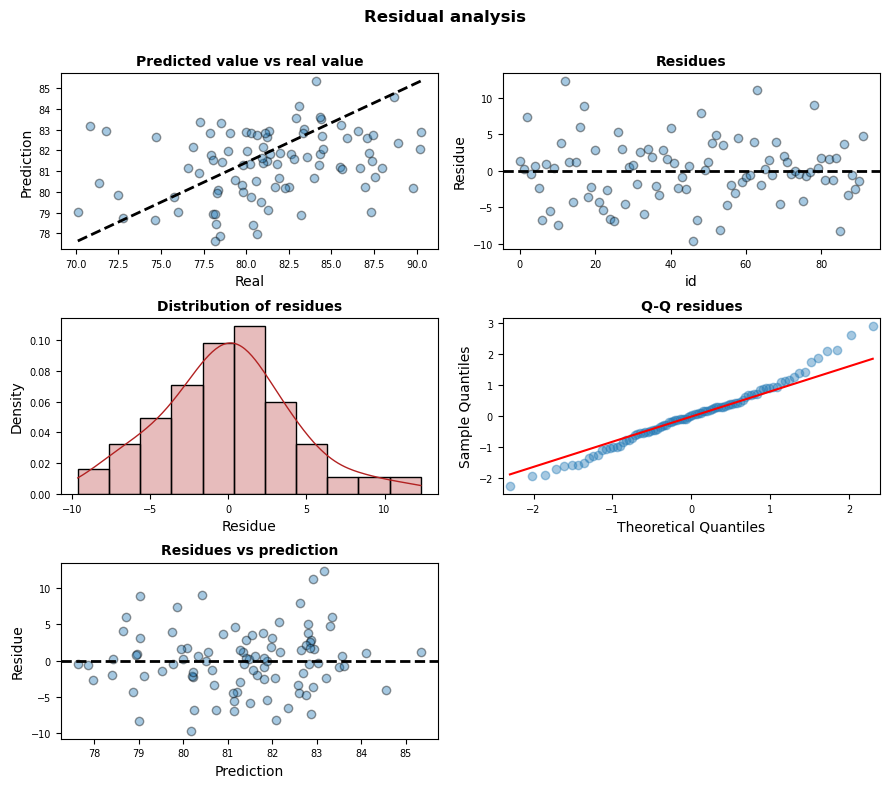

In [25]:
# Graphs
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 8))

axes[0, 0].scatter(y_train, prediction_train, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([y_train.min(), y_train.max()], [prediction_train.min(), prediction_train.max()],
                'k--', color = 'black', lw=2)
axes[0, 0].set_title('Predicted value vs real value', fontsize = 10, fontweight = "bold")
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Prediction')
axes[0, 0].tick_params(labelsize = 7)

axes[0, 1].scatter(list(range(len(y_train))), residues_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0, 1].set_title('Residues', fontsize = 10, fontweight = "bold")
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residue')
axes[0, 1].tick_params(labelsize = 7)

sns.histplot(
    data    = residues_train,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Distribution of residues', fontsize = 10,
                     fontweight = "bold")
axes[1, 0].set_xlabel("Residue")
axes[1, 0].tick_params(labelsize = 7)


sm.qqplot(
    residues_train,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1], 
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q residues', fontsize = 10, fontweight = "bold")
axes[1, 1].tick_params(labelsize = 7)

axes[2, 0].scatter(prediction_train, residues_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[2, 0].set_title('Residues vs prediction', fontsize = 10, fontweight = "bold")
axes[2, 0].set_xlabel('Prediction')
axes[2, 0].set_ylabel('Residue')
axes[2, 0].tick_params(labelsize = 7)

# Eliminate empty axes
fig.delaxes(axes[2,1])

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Residual analysis', fontsize = 12, fontweight = "bold");

### Normality test

We now verify if the residues follow a normal distribution using to statistical tests: *Shapiro-Wilk test* and *D'Agostino's K-squared test*. The latter includes a summary from **Statsmodels** with the name *Omnibus*.

On both tests, the null hypothesis considers that the data follows a normal distribution. Hence, if the *$p$-value* is not smaller than the selected significance level *alpha* there is no evidence to reject the statement that the data is normally distributed.

In [26]:
# Shapiro-Wilk test
# ==============================================================================
shapiro_test = stats.shapiro(residues_train)
shapiro_test

ShapiroResult(statistic=0.9868080019950867, pvalue=0.4858625531196594)

In [27]:
# D'Agostino's K-squared test
# ==============================================================================
k2, p_value = stats.normaltest(residues_train)
print(f"Statistic= {k2}, p-value = {p_value}")

Statistic= 2.3762158050202755, p-value = 0.30479742526149295


In our case the $p$-values are not smaller than $0.05$ which means that the residues are normally distributed

## Predictions

Now that we have trained our model, we can obtain predictions for new data. Models from **statsmodels** allow us to calculate predictions in two ways:

- `.predict()`: only gives predicted values.

- `.get_prediction().summary_frame()`: gives confidence intervals in addition to predicted values.

In [28]:
# Predictions with 95% confidence intervals
# ==============================================================================
predictions = modelf_noint.get_prediction(exog = X_train).summary_frame(alpha=0.05)
predictions.head(4)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,82.646967,0.837170,80.983266,84.310667,73.851205,91.442728
1,81.488690,0.522659,80.450014,82.527365,72.789474,90.187906
2,79.864109,1.158987,77.560865,82.167353,70.925292,88.802926
3,83.026279,1.419409,80.205500,85.847057,73.940338,92.112219


## Model error test

In [29]:
# Model error test
# ==============================================================================
#X_test = sm.add_constant(X_test, prepend=False)
predictions = modelf_noint.predict(exog = X_test[list(X_train.columns)])
rmse = root_mean_squared_error(
        y_true  = y_test,
        y_pred  = predictions
       )
print("")
print(f"The test error (rmse) is: {rmse}")


The test error (rmse) is: 4.510551938044547


In [30]:
movies['Fans'].min(),movies['Fans'].mean(),movies['Fans'].max()

(70.125, 81.4045263690691, 91.63636363636364)

In [31]:
modelf_noint.params

Year        0.038595
Budget     -0.013107
Revenue     0.003431
Critic_3    0.062957
dtype: float64

## Interpreting the results

So, the linear model thus generated follows the equation:

$$
Fans = 0.038595 Year -0.013107 Budget + 0.003431 Revenue + 0.062957 Critic_3
$$

`R-squared` indicates that the model is able to explain 99% of the observerd variability for the response variable. Furthermore, the *$p$-value* obtained in the F-test (`Prob (F-statistic) = 7.05e-152`) indicates that there is sufficient evidence that the variance explained by the model is greater than that of random chance.

For each increment in any of the predictor variables, the rating of the fans increases by 6.32 **on average**

## Making a prediction

Now, we will use our model to predict the rating of a movie that is not in the data frame.

In [32]:
titles = movies.index.values.tolist()
titles

['The shawshank redemption',
 'The godfather',
 'The godfather part ii',
 '12 angry men',
 'The lord of the rings the return of the king',
 'Pulp fiction',
 "Schindler's list",
 'Inception',
 'Fight club',
 'The lord of the rings the fellowship of the ring',
 'Forrest gump',
 'Il buono il brutto il cattivo',
 'The lord of the rings the two towers',
 'The matrix',
 'Goodfellas',
 'Star wars episode v  the empire strikes back',
 'Hamilton',
 'Gisaengchung',
 'Interstellar',
 'Cidade de deus',
 'Sen to chihiro no kamikakushi',
 'Saving private ryan',
 'The green mile',
 'La vita e bella',
 'Se7en',
 'The silence of the lambs',
 'Star wars',
 'Seppuku',
 'Joker',
 'Whiplash',
 'The intouchables',
 'The departed',
 'The pianist',
 'Gladiator',
 'American history x',
 'The usual suspects',
 'Leon',
 'Ter ator 2 judgment day',
 'Nuovo cinema paradiso',
 'Back to the future',
 'Once upon a time in the west',
 'Monster inc',
 'Hacksaw ridge',
 'Catch me if you can',
 'How to train your dragon',

In [33]:
##NUESTRAS PELICULAS 
'Top Gun:Maverick'.capitalize()
'Challengers'.capitalize()


'Challengers'

In [34]:
'Top gun:maverick' in titles or 'Top gun maverick' in titles or 'Challengers' in titles or 'Talk to me' in titles or 'No hard feelings' in  titles or 'TAR'.capitalize() in titles

False

In [35]:
modelf_noint.params

Year        0.038595
Budget     -0.013107
Revenue     0.003431
Critic_3    0.062957
dtype: float64

In [36]:
#NUESTRAS 5 PELICULAS 
favorites3 = pd.DataFrame({'Year':[2022,2024,2022,2023,2023],'Revenue':[1494,15.254,40.464,46.903,29.503],'Critic_3':[80,74,80,82,74],'Budget':[170,52.240,4.598,45.058,35.782]},index=['Top gun: maverick','Challengers',"Talk to me",'No hard feelings',"Tar"])


In [37]:
modelf_noint.predict(exog = favorites3)

Top gun: maverick    85.973119
Challengers          82.141975
Talk to me           83.153473
No hard feelings     82.809769
Tar                  82.367987
dtype: float64

## Is our model good? 
There is two approaches to this question, the first one is by only looking at the results and the second one involves all the aditional information about our model collected previously. The predicted results are very good, we chose famous movies which were filmed in recent years and the results are similars to the ones that the team predicted (we gave our personal opinioin). This a good way to check the results because the variable that we are predicting is an averge of all the people's rating in the database. 
The second way of looking at the efficiency of the model y by looking at the information about it. One of the most important values is the The rmse which tells us the error between the prediction and the actual value. This is important to know in order to determine if the model has to improve or if it completes the objective. In our case The test error (rmse) is: 4.5105519 which means that our predictions varies around 4.5 points from the real value. I believe that our model is good considering that our scale is from 1-100, and also the rmse is lower than the 10% of our mean of fans. 